<a href="https://colab.research.google.com/github/battistabiggio/ai4dev/blob/main/notebooks/AI4Dev_05_dnns_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning from images

In this notebook, we will load a dataset of images and go back to the classification problem.

We will load the MNIST dataset, a (labeled) dataset of images of handwritten digits. We can use the `torchvision` library to load and process data in the image domain. Additionally, we can use `matplotlib` for visualization and `pillow` for processing them.

We will also inspect how data can be loaded in PyTorch, how to create batches of images rather than passing the whole dataset at once, and also how to implement the learning phase (this last part won't be much different than the previous notebook).

samples in training dataset:  60000
samples in testing dataset:  10000
shape of sample
(28, 28)


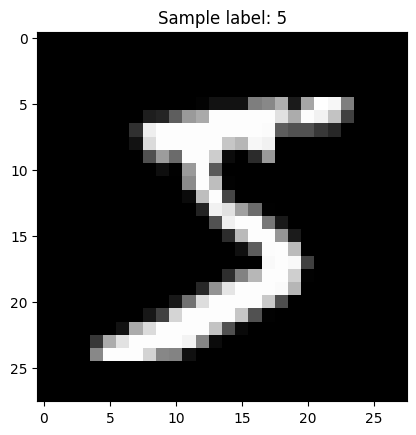

In [1]:
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

data_path = 'data'
mnist_train = datasets.MNIST(data_path,
                             train=True,
                             download=True)
mnist_validation = datasets.MNIST(data_path,
                                  train=False,
                                  download=True)

print("samples in training dataset: ", len(mnist_train))
print("samples in testing dataset: ", len(mnist_validation))

# first sample
image, label = mnist_train[0]
print("shape of sample")
print(np.array(image).shape)

# visualize the image
plt.imshow(image, cmap='gray')
plt.title(f"Sample label: {label}")
plt.show()

In torchvision we also have tools to preprocess the images, as well as converting them directly to PyTorch tensors.
As we load the image and convert to tensor, we can also inspect what changed. First, the shape now includes an additional dimension that is the batch index.

In [2]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
image_as_tensor = to_tensor(image)
print(image_as_tensor.shape)

torch.Size([1, 28, 28])


Additionally, we can also apply transformations to the images. These are in general useful if we want the model to generalize across different modifications of the samples, rather than learning only from well-placed input data.

We also define a function to visualize the image so that we can easily display it by passing a tensor without repeating lines of code in our notebook (matplotlib requires images in the format CHW - channels, height, width while pytorch encodes as HWC).

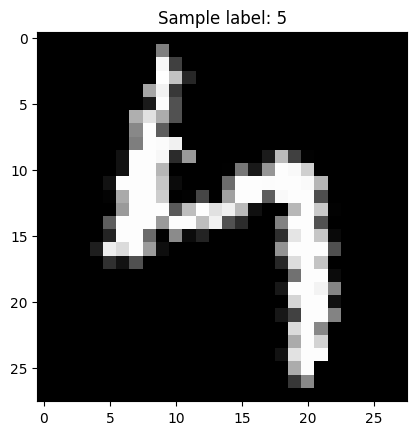

In [3]:
# random rotation between 0 an 90 degrees
rotation = transforms.RandomRotation(90)
rotated = rotation(image_as_tensor)

def display_image(image, label):
    # permute required to transform back in the PIL format
    plt.imshow(image.permute(1, 2, 0), cmap='gray')
    plt.title(f"Sample label: {label}")
    plt.show()

display_image(rotated, label)

We can also include the transforms in the dataset constructor, and then they will be applied to each sample upon loading.


In [4]:
tensor_mnist_train = datasets.MNIST(data_path,
                                    train=True,
                                    download=False,
                                    transform=transforms.ToTensor())

sample, label = tensor_mnist_train[0]

print("Sample type (as python object)")
print(type(sample))

print("Sample dtype (of the elements)")
print(sample.dtype)

print("Sample shape")
print(sample.shape)


Sample type (as python object)
<class 'torch.Tensor'>
Sample dtype (of the elements)
torch.float32
Sample shape
torch.Size([1, 28, 28])


Also, note that  the rescaling automatic if the inputs are recognized as images. This means that the images are automatically converted to Tensor and the pixels are divided by 255 (as [0, 255] is the range of values for the pixels). In this way, the values will become floating points in [0,1].

Reference:
- https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html

In [5]:
import numpy as np
print(f"image min: {np.array(image).min()}, image max: {np.array(image).max()}, dtype: {np.array(image).dtype}")
print(f"tensor min: {sample.min()}, tensor max: {sample.max()}, dtype: {sample.dtype}")

image min: 0, image max: 255, dtype: uint8
tensor min: 0.0, tensor max: 1.0, dtype: torch.float32


If we want to normalize the data with zero mean and standard deviation equal to 1, we have to compute these values on the training dataset and then apply the same transformation to the testing data. 
Here is the code to compute the mean and standard deviations for all features of the MNIST dataset. Note that when images contain three channels (RGB images), the values of mean and standard deviation are computed for each channel.

In [6]:
import torch
dataset = torch.stack([sample for sample, _ in tensor_mnist_train], dim=3)

print("dataset shape:")
print(dataset.shape)

means = dataset.view(1, -1).mean(dim=1)
stds = dataset.view(1, -1).std(dim=1)

print(f"means: {means}")
print(f"stds: {stds}")

dataset shape:
torch.Size([1, 28, 28, 60000])
means: tensor([0.1307])
stds: tensor([0.3081])


Now we can initialize the transform with the correct values (and we can make sure they are correct after transformation). If we want to apply more than one transformation, we can use the `torchvision.transforms.Compose` to chain the transformations (which will be applied in sequence).

In [7]:
normalize = transforms.Normalize(means, stds)
transformed_mnist_train = datasets.MNIST(data_path, train=True,
                                         download=False,
                                         transform=transforms.Compose([
                                         transforms.ToTensor(),
                                         normalize,]))

dataset = torch.stack([sample for sample, _ in transformed_mnist_train], dim=3)

# let's verify that the mean and standard deviation are now as we want them
means = dataset.view(1, -1).mean(dim=1)
stds = dataset.view(1, -1).std(dim=1)
print(f"mean: {means}")
print(f"std: {stds}")

mean: tensor([4.2517e-08])
std: tensor([1.0000])


Once we have our data normalized, we can create a model to classify the images.

Here are some important details:
- In the first layer, we have 784 features, while our images are 28x28. We first have to flatten the input (and take care that the batch size stays the same)
- Note that the model can (and should) process data in batches, thus the code should be independent from the batch size. This is why in the first step of the transform we have a -1 as the first argument of the `view` method. This -1 means that we leave the first dimension as it is, and we reshape the others to fit the new shape.
- The number of outputs is equal to the number of classes, as we want one node for each of the classes. We will pick the "winner" as the top score in the output of the model.


In [8]:
class MNISTModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 512)
        self.fc2 = torch.nn.Linear(512, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # we have to flatten the samples that are 28x28
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



Then, we can create our model and predict the label for one sample. Note that the model is not yet trained, so the output will be basically random. Also, the output has shape (n_samples, n_classes). To get the prediction for each sample (in this case it's only one, but let's make it in a way that will work also for batches), we can use the `tensor.argmax()` method. If we specify the argument `dim=1` we can take the argument of the maximum for each row (i.e., the predicted classes, as desired).

In [9]:

net = MNISTModel()
sample, label = transformed_mnist_train[0]

# prediction from untrained model
out = net(sample)
print("scores:", out)

# predicted class
pred = out.argmax(dim=1)
print("predicted class:", pred.item())
print("original label: ", label)

scores: tensor([[ 0.1693,  0.0982,  0.1845, -0.7322, -0.0712, -0.3645,  0.2340,  0.4162,
          0.0799,  0.2491]], grad_fn=<AddmmBackward0>)
predicted class: 7
original label:  5


For loading the data in batches, rather than single samples or entire datasets, we can use the `DataLoader` from `torch.utils.data`. We can specify the batch size of each batch here (i.e., how many images for each batch), and also whether to shuffle the indexes or not.

In [10]:
transformed_mnist_validation = datasets.MNIST(data_path, train=False,
                                              download=False,
                                              transform=transforms.Compose([
                                              transforms.ToTensor(),
                                              normalize,]))  # same normalize as train

train_loader = torch.utils.data.DataLoader(transformed_mnist_train,
                                           batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(transformed_mnist_validation,
                                         batch_size=64,
                                         shuffle=False)


Then, we can write our training loop as usual. Compared to our previous example with regression, in this case we are going to use the cross-entropy loss.

$$
L = - \sum_{c=1}^{C} y_c log(p_c)
$$

Where we loop through the classes and compare the prediction $p_c$ with the desired label $y_c$. This is implemented in PyTorch, so we only have to take care of instantiating the loss.

In [11]:
net = MNISTModel()
learning_rate = 1e-2
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 8], gamma=0.5)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

# train
for epoch in range(epochs):
    for samples, labels in train_loader:
        outputs = net(samples)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f"Epoch: {epoch + 1}, Loss: {loss}")

Epoch: 1, Loss: 0.35720548033714294
Epoch: 2, Loss: 0.4035971760749817
Epoch: 3, Loss: 0.35455450415611267
Epoch: 4, Loss: 0.32169651985168457
Epoch: 5, Loss: 0.2930167615413666
Epoch: 6, Loss: 0.22188043594360352
Epoch: 7, Loss: 0.2525811493396759
Epoch: 8, Loss: 0.5798184871673584
Epoch: 9, Loss: 0.39627477526664734
Epoch: 10, Loss: 0.20599155128002167


If we want to check how our model behaves, we cannot directly use the loss (it's not that informative). To compute a metric that has immediate meaning for us, we can compute the accuracy. In a multi-class setting, we have to count the number of labels that are equal to the targets, and divide by the total number of predictions. If we load the data in batches, we have to compute the accuracy as incremental.

In [12]:
accuracy = 0.0
total = 0
for samples, labels in val_loader:
    outputs = net(samples)
    predictions = outputs.argmax(dim=1)
    total += samples.shape[0]
    accuracy += (predictions.type(labels.dtype) == labels).float().sum()
accuracy = accuracy / total

print(f"Accuracy: {accuracy}")

Accuracy: 0.9348999857902527


Here, finally, let's report an improved training loop. Here we are also tracking the loss across the iterations and evaluating at each epoch. Moreover, we are also adding the instruction to load the data and model to a custom device (e.g., a GPU).

In [13]:
learning_rate = 1e-2
epochs = 5
device = torch.device('cpu')
net = MNISTModel()
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss_fn = torch.nn.CrossEntropyLoss()


def train_epoch(model, train_loader, optimizer, scheduler, loss_fn):
    train_loss = 0.0
    total = 0
    for samples, labels in train_loader:
        samples, labels = samples.to(device), labels.to(device)
        outputs = model(samples)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += samples.shape[0]
        train_loss += loss.sum().detach()
    train_loss /= total
    scheduler.step(train_loss)
    return train_loss.item()

def valid_epoch(model, val_loader, loss_fn):
    accuracy = 0.0
    validation_loss = 0.0
    total = 0
    for samples, labels in val_loader:
        samples, labels = samples.to(device), labels.to(device)
        outputs = net(samples)
        loss = loss_fn(outputs, labels)
        predictions = outputs.argmax(dim=1)
        accuracy += (predictions.type(labels.dtype) == labels).float().sum()
        total += samples.shape[0]
        validation_loss += loss.sum()
    validation_loss /= total
    accuracy = accuracy / total
    return validation_loss.item(), accuracy.item()

train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss = train_epoch(net, train_loader, optimizer, scheduler, loss_fn)
    val_loss, accuracy = valid_epoch(net, val_loader, loss_fn)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(epoch, accuracy)

# save the model
torch.save(net.state_dict(), "model.pth")

0 0.9156000018119812
1 0.9298999905586243
2 0.9426000118255615
3 0.9469000101089478
4 0.9513999819755554


Since we tracked the loss, we can also visualize it in a plot. Let's plot the training and validation loss. 
Observe that if the validation loss starts increasing (while the training loss keeps becoming smaller), this can be indication of overfitting.

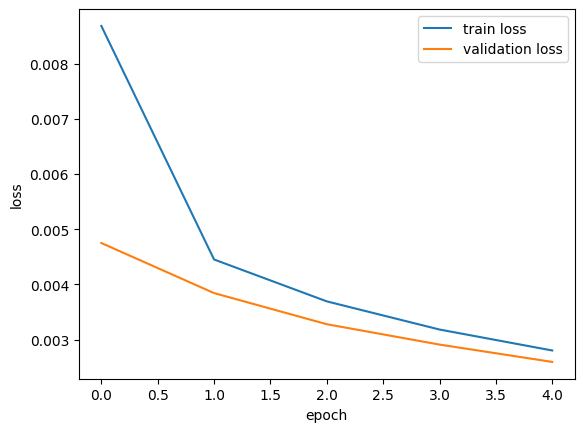

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

Let's finally understand what are the limitations of the fully-connected models. These models learn a function by considering all correlations between each combination of pixels in the image. However, for us, locality is much more important. 
As we ravel the images, we loose for instance the 2D structure of the image. For the model, this information is passed as raw, thus it will be equally important to connect pixels that are neighbors and pixels that are far away from each other.

Now we introduce a disturbance, where we shift the image and check performances of the model. 

The model is learning spurious correlations and also it is missing important information related to the locality of the pixels w.r.t. their neighborhood!

However, while the performance of the model drops substantially, the image for us still looks unchanged and we are able to recognize the digit. 

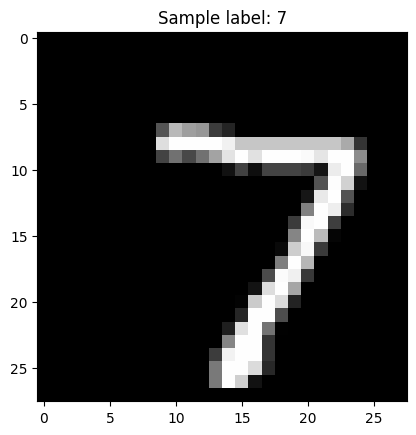

accuracy:  0.9513999819755554 accuracy after augmentation: 0.49149999022483826


In [15]:
def shift_pixels(t):
    shift = 3
    return torch.roll(t, shift)

# let's see how the network generalizes
augmented_mnist_validation = datasets.MNIST(data_path, train=False,
                                              download=False,
                                              transform=transforms.Compose([
                                              transforms.ToTensor(),
                                              transforms.Lambda(shift_pixels),
                                              normalize,]))
augmented_val_loader = torch.utils.data.DataLoader(augmented_mnist_validation,
                                         batch_size=64,
                                         shuffle=False)

images, labels = augmented_mnist_validation[0]
display_image(images, labels)

val_loss_augmented, accuracy_augmented = valid_epoch(net, augmented_val_loader, loss_fn)

print("accuracy: ", accuracy, "accuracy after augmentation:", accuracy_augmented)